In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

## Load data

In [2]:
INPUT_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
(train_data_ds, val_data_ds), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names
print(f"num_classes = {num_classes}, class_names = {class_names}")

num_classes = 5, class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [4]:
def resize_and_rescale(image, label):
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])
    image = (image / 255.0)
    return image, label

def encode_one_hot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def augment(image, label):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    height, width = shape[0], shape[1]
    min_size = tf.minimum(height, width)
    crop_size = tf.cast(tf.multiply(tf.cast(min_size, tf.float32), 0.8), tf.int32)
    image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    image = tf.image.random_flip_left_right(image)
    return image, label

train_data = (
    train_data_ds
    .shuffle(4096)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .map(encode_one_hot, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [5]:
def center_crop(image, label):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    height, width = shape[0], shape[1]
    size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(image, (height - size) // 2, (width - size) // 2, size, size)
    return image, label
    
val_data = (
    val_data_ds
    .map(center_crop, num_parallel_calls=AUTOTUNE)
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .map(encode_one_hot, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

## Show data

In [6]:
import utils

In [7]:
for x_batch, y_batch in train_data.take(1):
    print(f"x_batch.shape.shape = {x_batch.shape}")
    print(f"y_batch.shape.shape = {y_batch.shape}")

x_batch.shape.shape = (32, 224, 224, 3)
y_batch.shape.shape = (32, 5)


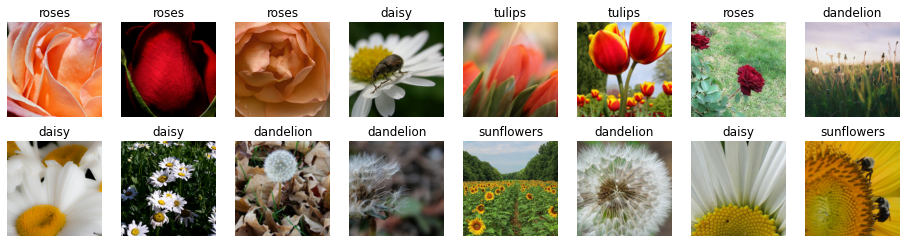

In [8]:
utils.plot_images(x_batch[:16], y_batch[:16], class_names)